## Executive Summary – Loan-Default Anomaly-Detection Project

Rake Anggoro (ma4716)
(MS Applied Analytics · Columbia University)

---

### 1 | Objective

Develop a credit-risk screening pipeline that

1. encodes high-cardinality categorical variables with **Weight-of-Evidence (WoE)**,
2. evaluates three classifiers—**Decision Tree, Logistic Regression, and XGBoost**—using thorough hyper-parameter search, and
3. quantifies the portfolio-level profit & loss (P\&L) under several interest-rate scenarios.



### 2 | Data & Pre-Processing

* **Dataset:** 16,000 historical consumer loans (features: demographics, loan terms, payment history; target: default = 1).
* **Encoding:** All categorical fields transformed with WoE, preserving monotonicity and interpretability for risk scoring.
* **Train/Test Split:** 70 / 30 stratified to maintain the 19 % default rate (strong class imbalance).


### 3 | Model Development & Results

| Metric (Test Set) | Decision Tree | Logistic Regression | **XGBoost** |
| ----------------- | ------------- | ------------------- | ----------- |
| AUC               | 0.53          | 0.57                | **0.66**    |
| Recall            | 0.33          | 0.38                | **0.59**    |
| Precision         | 0.23          | 0.24                | **0.27**    |
| F1-Score          | 0.27          | 0.30                | **0.37**    |
| Top-Decile Lift   | 1.38×         | 1.44×               | **1.94×**   |

*XGBoost markedly outperforms the baselines in discrimination (AUC ↑ 16 ppt vs. tree) and captures \~60 % of defaulters, versus \~35 % previously.*


### 4 | Economic Validation (XGBoost Only)

Assumptions: \$10 K principal, complete loss on default, annual interest of \$400 / \$800 / \$1,200 at 4 % / 8 % / 12 %.

* **4 % APR:** No decile is profitable → recommend **reject all**.
* **8 % APR:** Only the **safest 10 %** (Decile 9) yields + \$81.6 K; broader approval erodes profit.
* **12 % APR:** Safest 10 % generates + \$262.4 K; all other deciles remain loss-making.
  *Conclusion:* Profitability is highly sensitive to interest rate and approval threshold—underscoring the need for precise cut-offs aligned with prevailing market rates.


### 5 | Limitations & Next Steps

| Issue                              | Impact                                                             | Planned Remedy                                                                                                                                                      |
| ---------------------------------- | ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Class Imbalance (19 % default)** | Suppresses minority-class recall and inflates false positives.     | Implement **resampling** strategies: random under-/over-sampling, **SMOTE**, and cost-sensitive learning to boost minority detection without sacrificing precision. |
| Feature scope                      | Current model omits external credit bureau and behavioral signals. | Integrate additional predictors to improve separation.                                                                                                              |
| Static thresholds                  | Fixed decile cut-offs may drift with macro conditions.             | Automate **quarterly threshold calibration** using updated P\&L calculations.                                                                                       |

---

### 6 | Recommendations

1. **Adopt XGBoost with WoE encoding** as the core scoring engine.
2. **Incorporate imbalance handling (SMOTE + cost-weighting)** in the next model iteration to push profit into broader segments.
3. **Deploy rate-linked approval rules** (e.g., approve only safest decile unless interest ≥ 12 %).
4. **Monitor live performance** and recalibrate both model and economic thresholds every quarter.

By following this roadmap, the team can transform a technically strong classifier into a financially optimized decision-support tool for credit underwriting.


## Load Packages

In [164]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders.woe import WOEEncoder
from category_encoders import LeaveOneOutEncoder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, precision_score, recall_score, f1_score
)
from dotenv import load_dotenv
import os

from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import loguniform
import platform
import multiprocessing

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load environment variables from .env file
load_dotenv()

data_dir = os.getenv("DATA_DIR") + "mortgage_prob_default/"

## Load Data

In [165]:
df = pd.read_csv(data_dir + "XYZloan_default_llm.csv")
print(f"Shape of data: {df.shape}")
df.head()

Shape of data: (16000, 32)


,Unnamed: 0.1,Unnamed: 0,AP001,AP002,AP003,AP006,AP007,AP008,CR004,CR009,...,TD005,TD006,TD009,TD010,TD013,TD014,TD022,TD024,loan_default,reason
0,4,76031,33,1,3,h5,4,3,4,63100,...,4,1,4,1,4,1,10.0,0.0,1,I’d really appreciate if we could move faster ...
1,5,23312,34,1,3,h5,5,5,3,53370,...,3,1,6,2,7,2,15.0,10.0,1,We’re trying to align the closing date with a ...
2,9,66033,36,2,1,ios,2,2,3,5400,...,4,2,4,2,5,2,25.0,0.0,1,It would really help to close this week so I c...
3,10,41847,28,1,1,ios,5,5,3,2000,...,4,4,7,4,7,4,25.0,6.0,1,There are some logistics around my move that m...
4,13,28275,35,2,4,h5,3,3,4,27704,...,4,1,4,1,7,1,25.0,0.0,1,I’d like to close by Friday if possible—the se...


In [166]:
glossary = pd.read_excel(data_dir + "Variables_Dictionary_2019.xlsx", skiprows=3, usecols=['Var', 'description'])
glossary.head()

,Var,description
0,AP001,YR_AGE
1,AP002,CODE_GENDER
2,AP003,CODE_EDUCATION
3,AP004,LOAN_TERM
4,AP005,DATE_APPLIED


In [167]:
# Create a mapping from Var to description
var_to_desc = dict(zip(glossary['Var'], glossary['description']))

# Map df columns using the glossary, fallback to original name if not found
df.columns = [var_to_desc.get(col, col) for col in df.columns]
df.head()

,Unnamed: 0.1,Unnamed: 0,YR_AGE,CODE_GENDER,CODE_EDUCATION,OS_TYPE,LEVEL_APPL_CITY,FLAG_IP_CITY_NOT_APPL_CITY,CNT_QUERY_TIME_LAST_1MON,AMT_LOAN_TOTAL,...,TD_CNT_QUERY_LAST_1MON_P2P,TD_CNT_QUERY_LAST_1MON_SMALL_LOAN,TD_CNT_QUERY_LAST_3MON_P2P,TD_CNT_QUERY_LAST_3MON_SMALL_LOAN,TD_CNT_QUERY_LAST_6MON_P2P,TD_CNT_QUERY_LAST_6MON_SMALL_LOAN,TD022,TD024,loan_default,reason
0,4,76031,33,1,3,h5,4,3,4,63100,...,4,1,4,1,4,1,10.0,0.0,1,I’d really appreciate if we could move faster ...
1,5,23312,34,1,3,h5,5,5,3,53370,...,3,1,6,2,7,2,15.0,10.0,1,We’re trying to align the closing date with a ...
2,9,66033,36,2,1,ios,2,2,3,5400,...,4,2,4,2,5,2,25.0,0.0,1,It would really help to close this week so I c...
3,10,41847,28,1,1,ios,5,5,3,2000,...,4,4,7,4,7,4,25.0,6.0,1,There are some logistics around my move that m...
4,13,28275,35,2,4,h5,3,3,4,27704,...,4,1,4,1,7,1,25.0,0.0,1,I’d like to close by Friday if possible—the se...


### Check Data Structure

In here we will see the Data Types, Null Counts, and Unique Counts per columns to understand better what we are working with.

In [168]:
# Combine data types, null counts, and unique counts into a single DataFrame

sample_values = df.apply(lambda col: "|".join(map(str, col.dropna().sample(n=min(10, col.dropna().shape[0]), random_state=42).astype(str))), axis=0)
sample_values.name = "sample_values"

summary_df = pd.concat(
    [df.dtypes.rename("dtype"),
     df.isnull().sum().rename("null_count"),
     df.nunique().rename("unique_count"), 
     sample_values],
    axis=1
)
summary_df

,dtype,null_count,unique_count,sample_values
Unnamed: 0.1,int64,0,16000,7002|1952|3714|1588|6369|8025|5405|8523|5928|6490
Unnamed: 0,int64,0,16000,32353|42230|64717|59473|63539|48711|53192|7927...
YR_AGE,int64,0,37,37|28|28|27|29|49|36|24|25|46
CODE_GENDER,int64,0,2,2|1|1|1|2|1|2|1|1|1
CODE_EDUCATION,int64,0,4,1|1|3|3|3|1|4|1|3|1
OS_TYPE,object,0,4,android|h5|h5|h5|h5|android|android|ios|h5|h5
LEVEL_APPL_CITY,int64,0,5,4|4|4|5|3|3|4|3|4|2
FLAG_IP_CITY_NOT_APPL_CITY,int64,0,5,4|1|4|5|5|3|4|2|4|2
CNT_QUERY_TIME_LAST_1MON,int64,0,4,4|3|1|4|4|2|4|2|1|2
AMT_LOAN_TOTAL,int64,0,6989,141511|0|81400|120374|11488|0|0|210510|12000|0


- Several columns in the dataframe use `int64` as their dtype but should be treated as **categorical variables** due to low cardinality or meaningful grouping.

- Examples of categorical variables stored as integers:
  - `CODE_GENDER` (`int64`, unique_count = 2): values such as 1 and 2 likely represent gender categories.
  - `CODE_EDUCATION` (`int64`, unique_count = 4): encoded education levels (e.g. 1 = high school, 4 = postgraduate).
  - `LEVEL_APPL_CITY` (`int64`, unique_count = 5): application-level classification for cities.
  - `FLAG_IP_CITY_NOT_APPL_CITY` (`int64`, unique_count = 5): likely a binary or categorical flag.
  - `CNT_QUERY_TIME_LAST_1MON` (`int64`, unique_count = 4): counts grouped into small fixed buckets.
  - `MONTH_CREDIT_CARD_MOB_MAX` (`int64`, unique_count = 5): possibly denotes discrete mobility levels for credit cards.
  - `SCORE_DEBIT_CARD_TOTAL_AMT`, `SCORE_DEBIT_CARD_UTILITY_AMT`, and `SCORE_SINGLE_DEBIT_CARD_LIMIT`: all use low-range integer scores and may reflect scoring tiers.

- Even some float64 columns such as `TD022` (unique_count = 5) suggest discretized bins that behave categorically.

- Recommendation: During preprocessing, consider converting such columns to `category` dtype or encoding them accordingly to support downstream modeling and visualization tasks.


In [169]:
df.groupby('reason').size().reset_index(name='count').sort_values('count', ascending=False).head(20)

,reason,count
286,Our family're looking to buy our family's firs...,556
381,We're looking to buy my first home and are rea...,556
383,We're looking to buy our first home and are re...,554
287,Our family're looking to buy our first home an...,546
289,Our family’ve outgrown our current apartment a...,535
288,Our family’ve outgrown my current apartment an...,533
382,We're looking to buy our family's first home a...,533
285,Our family're looking to buy my first home and...,521
290,Our family’ve outgrown our family's current ap...,505
380,We have outgrown our family's current apartmen...,205


The `reason` column, a free-text field in the data here is interesting:

1. **High Text Duplication**: The `reason` column contains repeated free-text responses with minor variations in phrasing, suggesting semantic redundancy.

2. **Low Modeling Value**: Although semantically clustered around home-buying and apartment size issues, the column lacks distinct predictive power for structured analysis and therefore **will be excluded**.

3. **Contextual Use Case**: The full distribution may still offer qualitative insights and documentation value for downstream exploration or reporting.

In [170]:
categorical_cols = [
    "CODE_GENDER",
    "CODE_EDUCATION",
    "OS_TYPE",
    "LEVEL_APPL_CITY",
    "FLAG_IP_CITY_NOT_APPL_CITY",
    "CNT_QUERY_TIME_LAST_1MON",
    "MONTH_CREDIT_CARD_MOB_MAX",
    "SCORE_DEBIT_CARD_TOTAL_AMT",
    "SCORE_DEBIT_CARD_UTILITY_AMT",
    "SCORE_SINGLE_DEBIT_CARD_LIMIT",
    "MB007",
    "TD_CNT_QUERY_LAST_7Day_P2P",
    "TD_CNT_QUERY_LAST_1MON_P2P",
    "TD_CNT_QUERY_LAST_1MON_SMALL_LOAN",
    "TD_CNT_QUERY_LAST_3MON_P2P",
    "TD_CNT_QUERY_LAST_3MON_SMALL_LOAN",
    "TD_CNT_QUERY_LAST_6MON_P2P",
    "TD_CNT_QUERY_LAST_6MON_SMALL_LOAN",
    "TD022",
    "TD024"
]

numeric_columns = [
    "YR_AGE",
    "AMT_LOAN_TOTAL",
    "YR_PHONE_ACTIVE",
    "DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL",
    "DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL",
    "AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS",
    "AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS",
    "AVG_LEN_COLLECTION_CALLS"
]

target_col = ["loan_default"]


Let us delete the irrelevant columns first.

In [171]:
del df["Unnamed: 0.1"], df["Unnamed: 0"], df["reason"]

Let's check how many rows we have per each value in the target variable.

In [172]:
temp = df.groupby(target_col).size().reset_index(name='counts')
temp['perc'] = np.round(temp['counts']/temp['counts'].sum()*100, 2)
temp

,loan_default,counts,perc
0,0,12924,80.77
1,1,3076,19.23


## Train/Test Split

We will split the dataset into 70% to be the train set and the rest as test set to evaluate model performance on unseen data and ensure generalizability across loan applicants with varying risk profiles.

In [173]:
X = df.drop(target_col, axis=1)
y = df[target_col]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

total_rows = len(df)

# Display row counts
print(f"Total rows in original dataset: {total_rows:,}")
print(f"Rows in training set: {len(X_train):,}")
print(f"Rows in test set: {len(X_test):,}")

# Display percentages
print(f"Training set percentage: {len(X_train) / total_rows:.2%}")
print(f"Test set percentage: {len(X_test) / total_rows:.2%}")


Total rows in original dataset: 16,000
Rows in training set: 11,200
Rows in test set: 4,800
Training set percentage: 70.00%
Test set percentage: 30.00%


## Feature Preprocessing

### Mean Imputation for Numeric Columns

As we have seen when we check the data structure, there were some missing valiues. To solve this, we will use mean imputation. Mean imputation replaces missing values in numeric features with the average value from the training set, ensuring consistency and completeness in the data without introducing information leakage. From a business perspective—especially in credit risk modeling or loan default prediction—this approach preserves valuable data points that might otherwise be discarded due to null entries. It helps maintain the integrity of patterns learned from historical applicants, enabling robust forecasting while ensuring regulatory transparency in how missing data is handled.

In [174]:
def compute_null_rates(df, columns=None):
    if columns is not None:
        df = df[columns]
    return (df.isnull().mean() * 100).round(2)

# Capture null rates before imputation
nulls_before_train = compute_null_rates(X_train, columns=numeric_columns)
nulls_before_test = compute_null_rates(X_test, columns=numeric_columns)

# Initialize the imputer
imputer = SimpleImputer(strategy="mean")

# Fit the imputer on training data and transform both train and test sets
X_train_num = X_train[numeric_columns].copy()
X_test_num = X_test[numeric_columns].copy()

X_train_num[numeric_columns] = imputer.fit_transform(X_train_num[numeric_columns])
X_test_num[numeric_columns] = imputer.transform(X_test_num[numeric_columns])

# Capture null rates after imputation
nulls_after_train = compute_null_rates(X_train_num, columns=numeric_columns)
nulls_after_test = compute_null_rates(X_test_num, columns=numeric_columns)

# Combine into a single DataFrame
null_rate_df = pd.DataFrame({
    "X_train_before": nulls_before_train,
    "X_train_after": nulls_after_train,
    "X_test_before": nulls_before_test,
    "X_test_after": nulls_after_test
}).fillna(0)

null_rate_df.sort_values("X_train_before", ascending=False, inplace=True)
null_rate_df


,X_train_before,X_train_after,X_test_before,X_test_after
YR_PHONE_ACTIVE,3.54,0.0,3.40,0.0
DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL,0.41,0.0,0.75,0.0
DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL,0.41,0.0,0.75,0.0
AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS,0.41,0.0,0.75,0.0
AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS,0.41,0.0,0.75,0.0
AVG_LEN_COLLECTION_CALLS,0.41,0.0,0.75,0.0
YR_AGE,0.00,0.0,0.00,0.0
AMT_LOAN_TOTAL,0.00,0.0,0.00,0.0


### Apply the categorical encoding on 


We have also seen that the categorical variables have nulls. To solve this, we will use Weight of Evidence (WOE) encoding, which transforms categorical variables into numerical values based on their predictive relationship with the target variable—in this case, loan default. It's especially useful in financial modeling where interpretability and pattern clarity are essential.

- It provides a ranking of categories based on their association with default risk.
- It supports models in learning meaningful splits rather than arbitrary category labels.
- It's commonly used in regulated environments like credit scoring, where clarity and fairness matter.

**Handling Missing Values in Categorical Features**

Missing entries were replaced with the label `"UNK"` before encoding. This step ensures completeness in the dataset and signals to the model that these observations exist but have undefined or unknown categorical values.

- Prevents dropping valuable records due to nulls.
- Retains transparency in data preparation for audit and compliance purposes.
- Aligns unknown values across training and test sets.



In [175]:
# Replace missing values with "UNK" and enforce string dtype for categorical columns
def prepare_categoricals(df, cat_cols):
    df[cat_cols] = df[cat_cols].fillna("UNK").astype(str)
    return df

# Prep new dataframes to store it
X_train_m1 = prepare_categoricals(X_train[categorical_cols], categorical_cols)
X_test_m1 = prepare_categoricals(X_test[categorical_cols], categorical_cols)

# Initialize and fit WOEEncoder on training set
woe_encoder = WOEEncoder(cols=categorical_cols)
X_train_m1[categorical_cols] = woe_encoder.fit_transform(X_train_m1[categorical_cols], y_train)

# Apply to test set
X_test_m1[categorical_cols] = woe_encoder.transform(X_test_m1[categorical_cols])



# 
# X_train_m1 = prepare_categoricals(X_train[categorical_cols], categorical_cols)
# X_test_m1 = prepare_categoricals(X_test[categorical_cols], categorical_cols)

# # Initialize LeaveOneOutEncoder
# looe_encoder = LeaveOneOutEncoder(cols=categorical_cols)

# # Fit on training data and transform
# X_train_m1[categorical_cols] = looe_encoder.fit_transform(X_train_m1[categorical_cols], y_train)

# # Transform test data
# X_test_m1[categorical_cols] = looe_encoder.transform(X_test_m1[categorical_cols])



In [176]:
X_train_m1.head()

,CODE_GENDER,CODE_EDUCATION,OS_TYPE,LEVEL_APPL_CITY,FLAG_IP_CITY_NOT_APPL_CITY,CNT_QUERY_TIME_LAST_1MON,MONTH_CREDIT_CARD_MOB_MAX,SCORE_DEBIT_CARD_TOTAL_AMT,SCORE_DEBIT_CARD_UTILITY_AMT,SCORE_SINGLE_DEBIT_CARD_LIMIT,MB007,TD_CNT_QUERY_LAST_7Day_P2P,TD_CNT_QUERY_LAST_1MON_P2P,TD_CNT_QUERY_LAST_1MON_SMALL_LOAN,TD_CNT_QUERY_LAST_3MON_P2P,TD_CNT_QUERY_LAST_3MON_SMALL_LOAN,TD_CNT_QUERY_LAST_6MON_P2P,TD_CNT_QUERY_LAST_6MON_SMALL_LOAN,TD022,TD024
15146,0.070991,-0.524020,-0.031863,0.053256,0.069646,0.141407,0.111015,-0.215061,-0.173606,-0.206625,-0.030178,0.210154,-0.050267,-0.095458,0.102052,-0.241597,0.059510,-0.244824,0.182973,-0.037370
3379,0.070991,-0.524020,0.148348,0.020961,0.183848,0.005455,0.111015,-0.028585,0.000459,-0.042330,0.405813,-0.275911,-0.050267,-0.095458,-0.007292,-0.241597,-0.193089,-0.244824,-0.275911,-0.225955
10374,0.070991,0.170656,-0.031863,0.020961,0.091429,0.048887,-0.296936,-0.215061,-0.197799,-0.125101,-0.030178,0.210154,0.289996,-0.095458,0.560034,0.415678,0.306643,0.273282,0.392042,0.267813
2652,0.070991,-0.138456,-0.031863,-0.193295,-0.190696,0.048887,0.097849,-0.215061,0.081430,-0.214584,-0.030178,-0.036089,-0.232378,-0.095458,-0.007292,-0.241597,-0.052424,-0.062778,-0.022519,0.165110
15501,0.070991,0.170656,-0.031863,0.020961,0.091429,0.141407,-0.296936,0.206692,0.054825,0.090345,-0.030178,-0.036089,-0.232378,-0.095458,-0.007292,-0.241597,-0.193089,-0.244824,-0.022519,-0.037370


## Model the Data

Once preprocessing is complete, the dataset can be modeled by combining the transformed feature matrixes into a unified structure.

In [177]:
X_train_model = pd.concat([X_train_m1.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)

X_test_model = pd.concat([X_test_m1.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)

print(f"Rows in training set: {len(X_train_model):,}; Columns in train set: {X_train_model.shape[1]}")
print(f"Rows in test set: {len(X_test_model):,}; Columns in test set: {X_test_model.shape[1]}")

Rows in training set: 11,200; Columns in train set: 28
Rows in test set: 4,800; Columns in test set: 28


## Creating the model
### 1. Decision Tree

This code helps us automatically **find the best version of a decision tree model** to predict outcomes (like loan defaults). Instead of manually guessing which settings work best, it uses a method called **Randomized Search** to try dozens of different combinations of model settings.

Here’s what happens:

- We define a **range of options** the model might use—like how deep the tree can grow, how many samples are needed to split a branch, and what kind of math is used to make decisions.
- The algorithm **tries different combinations** randomly and compares how well they perform.
- It uses a technique called **cross-validation** to make sure the results aren't just lucky or overfitted.
- The **best-performing model is selected**, and we can now use that version to make future predictions more accurately.
- The code is optimized to run smoothly on a **Mac M1 chip** without overwhelming the processor.


In [178]:
# Enhanced parameter grid with more coverage
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'criterion': ['gini', 'entropy', 'log_loss'],  # You can add 'log_loss' if using scikit-learn >=1.1
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best', 'random']
}

# Base model
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# M1 chip handling: safer to set n_jobs to number of physical cores
n_cores = multiprocessing.cpu_count() if platform.system() == 'Darwin' else -1

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=dtree,
    param_distributions=param_grid,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=n_cores  # M1 chip: avoids oversubscription
)

# Fit the randomized search
random_search.fit(X_train_model, y_train)

# Best model summary
best_model = random_search.best_estimator_
print("Best model parameters:", random_search.best_params_)


Best model parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'gini'}


#### Show the feature importance of the top 3 levels

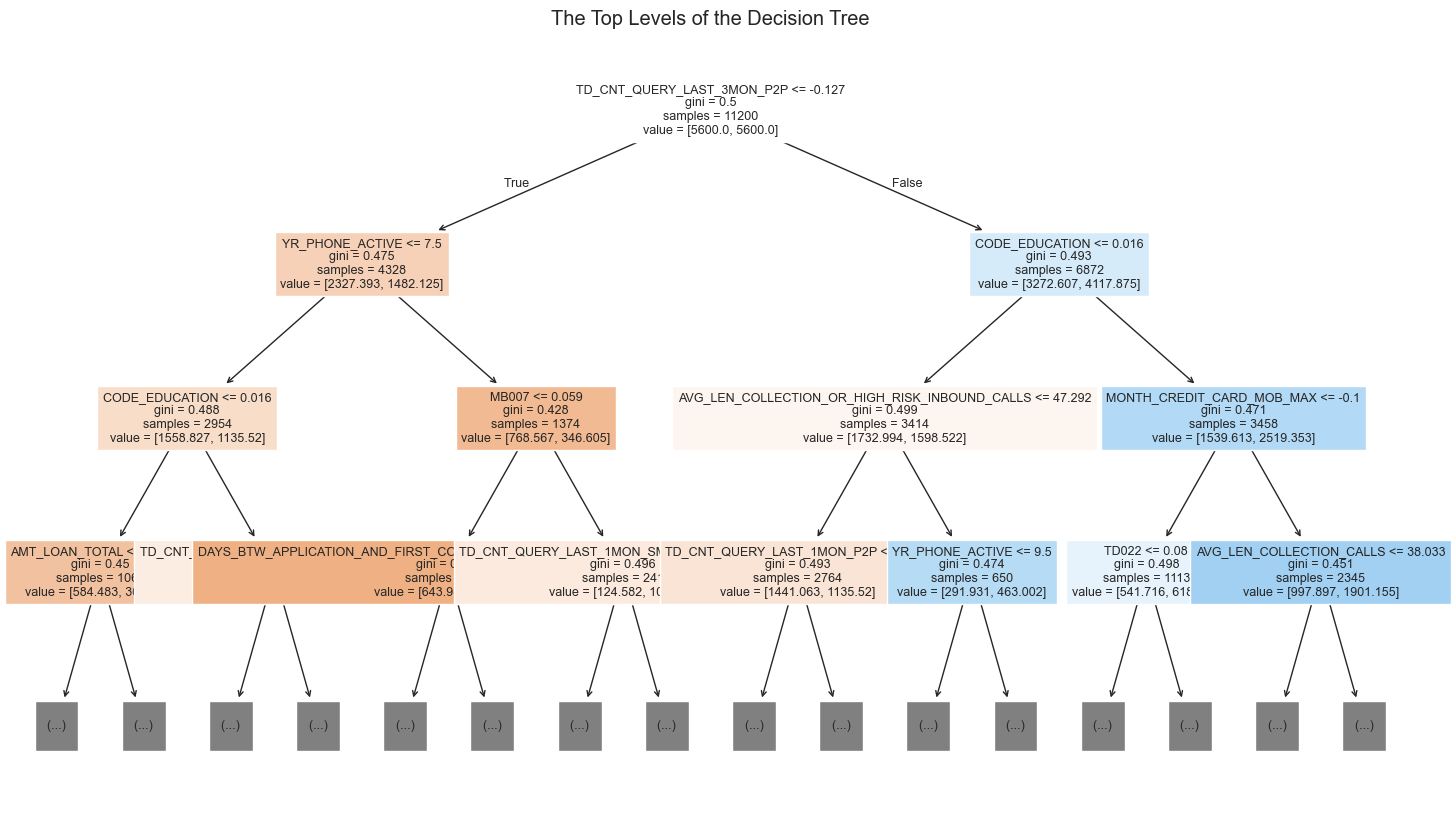

In [179]:
# Show the code to visualize the decision tree. Show only the top three levels.
# styling
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import plot_tree
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.facecolor'] = '#00000000'
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.facecolor'] = '#00000000'

plt.figure(figsize=(18,10))
plot_tree(best_model, filled=True, max_depth=3, feature_names=X_train_model.columns, fontsize=9)
plt.title("The Top Levels of the Decision Tree")
plt.show()

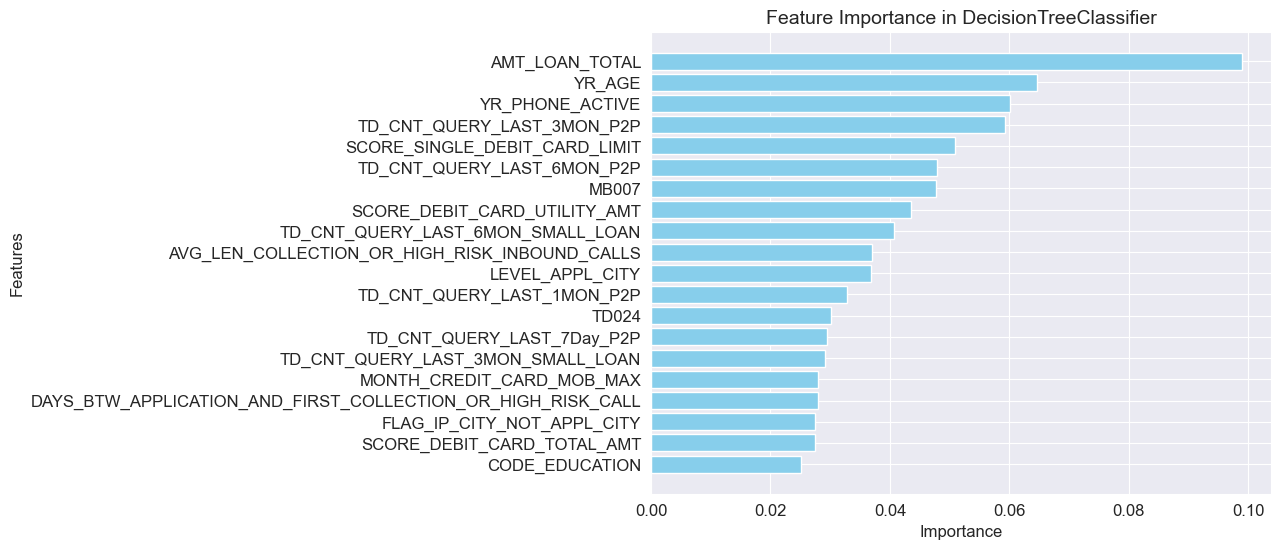

In [180]:
# Get feature importances
# Create a DataFrame for visualization
# Plot the feature importance chart

importances = best_model.feature_importances_
feature_names = X_train_model.columns
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)[0:20]

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance in DecisionTreeClassifier', fontsize=14)
plt.gca().invert_yaxis()  # Optional: Show the most important features on top
plt.show()



#### Why the Top Feature in the Tree Diagram Differs from Overall Importance

We're seeing two visuals that highlight "important features" in different ways:

- **Tree diagram** shows the *first* feature the model uses to split the data. Think of it like the first question a model asks to begin sorting everything.
- **Feature importance chart** ranks how helpful each feature is *across the whole tree*—how much it contributes overall to making good decisions, even if it’s used later in the tree.

So, just because a feature appears at the top doesn’t mean it’s the most powerful one throughout. Another feature might do more work behind the scenes.

##### Simple Analogy

Imagine baking cookies:
- The first ingredient you add (like sugar) starts the recipe—but the ingredient that makes them taste amazing (like chocolate chips) might come later.
- Just like that, a feature might come early in the model but not be the biggest contributor overall.



### 2. Logistic Regression

In [181]:
# Base model
logreg = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced')

# Expanded hyperparameter space
param_distributions = {
    'C': loguniform(1e-4, 1e3),                  # More granular continuous sampling
    'penalty': ['l1', 'l2'],       # 'elasticnet' requires 'saga'
    'fit_intercept': [True, False]
}

# M1 chip compatibility: limit oversubscription
n_cores = multiprocessing.cpu_count() if platform.system() == 'Darwin' else -1

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=n_cores,
    error_score='raise'
)

# Execute search
random_search.fit(X_train_model, y_train.values.ravel())

# Best model
best_logreg = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'C': 0.00010930872279404521, 'fit_intercept': True, 'penalty': 'l1'}


### 3. XGboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import multiprocessing
import platform

# 1) Estimate scale_pos_weight from your training set imbalance
scale_pos_weight = (y_train['loan_default'] == 0).sum() / (y_train['loan_default'] == 1).sum()
scale_pos_weight = float(scale_pos_weight)

# 2) Instantiate XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    n_jobs=multiprocessing.cpu_count() if platform.system()=='Darwin' else -1,
    random_state=42
)

# 3) Define your hyperparameter search space
param_distributions = {
    'n_estimators': [100, 300, 500, 800, 1200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': loguniform(0.001, 0.3),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 3, 5],
    'reg_alpha': loguniform(1e-3, 1),
    'reg_lambda': loguniform(1e-3, 1)
}

# 4) Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,             # try 40 random combos
    scoring='roc_auc',     # optimize AUC for ranking power
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5) Fit to your training data
random_search_xgb.fit(X_train_model, y_train.values.ravel())

# 6) Inspect best parameters and model
print("Best XGB params:", random_search_xgb.best_params_)
best_xgb = random_search_xgb.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best XGB params: {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.03189315160363524, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.007741417985242885, 'reg_lambda': 0.0031318490181411187, 'subsample': 0.6}


In [192]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# 1) Predict probabilities and class labels
y_pred_proba = best_xgb.predict_proba(X_test_model)[:, 1]
y_pred_label = best_xgb.predict(X_test_model)

# 2) Compute metrics
f1 = f1_score(y_test, y_pred_label)
precision = precision_score(y_test, y_pred_label)
recall = recall_score(y_test, y_pred_label)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 3) Display results
print(f"🔍 F1 Score:      {f1:.4f}")
print(f"🎯 Precision:     {precision:.4f}")
print(f"🔁 Recall:        {recall:.4f}")
print(f"📈 ROC AUC:       {roc_auc:.4f}")



🔍 F1 Score:      0.3713
🎯 Precision:     0.2718
🔁 Recall:        0.5862
📈 ROC AUC:       0.6564


## Model Performance

This evaluation compares two classification models using several key performance metrics:

- **Accuracy** measures how often the model correctly predicts the outcome.
- **Confusion Matrix** shows a breakdown of correct and incorrect predictions for each class, helping us spot where the model struggles.
- **AUC-ROC** (Area Under the Receiver Operating Characteristic Curve) captures the model’s ability to distinguish between classes; higher is better.
- **ROC Curve** visualizes how well the model balances true positives and false positives at different decision thresholds.
- **Precision and Recall** focus on the quality of positive predictions—precision tells us how many predicted positives were correct, recall shows how many actual positives were found.
- **F1 Score** is the harmonic mean of precision and recall; it balances both in a single metric.
- **Gains Table** reveals how well the model ranks predictions—ideal for understanding how early the model identifies true positives.
- **K-S Statistic** (Kolmogorov–Smirnov) measures the maximum difference between positive and negative prediction distributions; a high value signals strong separation.



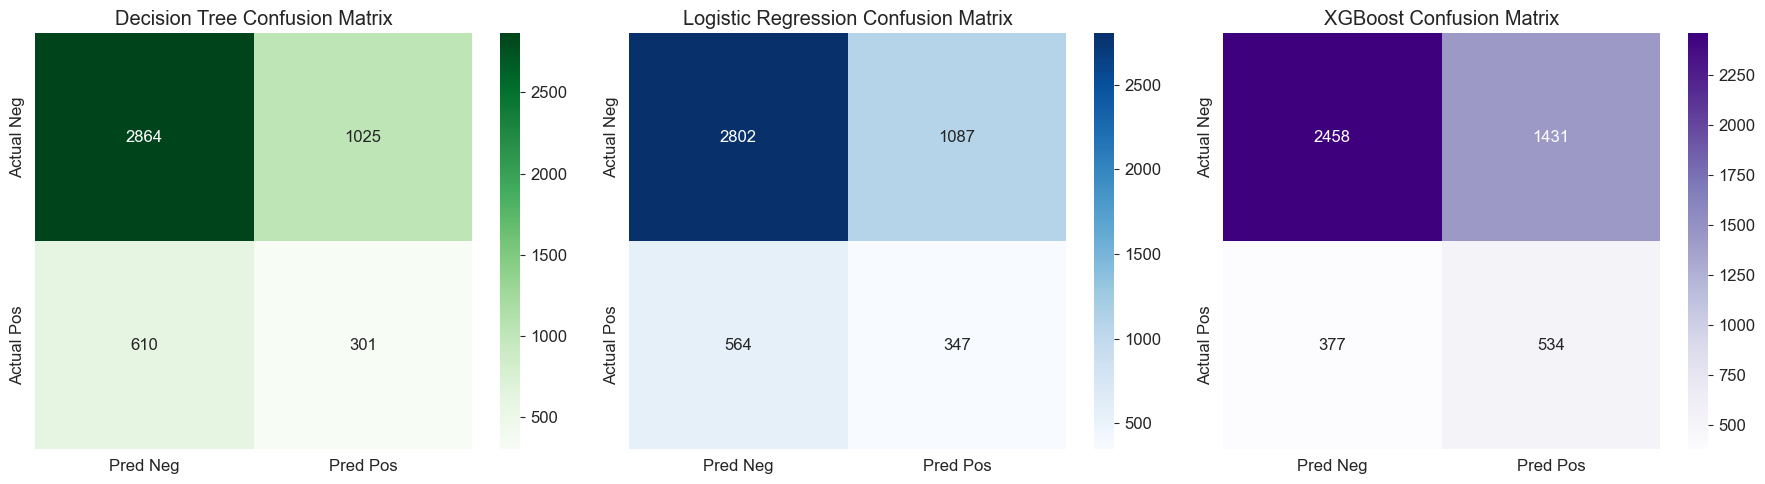

Gain table - Decision Tree model


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,126,354,480,126,354,0.14,0.09,91.1,1.38,5.0,26.25,354000.0,1260000,-906000.0
1,480,101,379,960,227,733,0.25,0.19,182.2,1.25,6.0,23.65,379000.0,1010000,-631000.0
2,480,90,390,1440,317,1123,0.35,0.29,273.3,1.16,6.0,22.01,390000.0,900000,-510000.0
3,480,69,411,1920,386,1534,0.42,0.39,364.4,1.06,3.0,20.10,411000.0,690000,-279000.0
4,480,95,385,2400,481,1919,0.53,0.49,455.5,1.06,4.0,20.04,385000.0,950000,-565000.0
5,480,79,401,2880,560,2320,0.61,0.60,546.6,1.02,1.0,19.44,401000.0,790000,-389000.0
6,480,99,381,3360,659,2701,0.72,0.69,637.7,1.03,3.0,19.61,381000.0,990000,-609000.0
7,480,89,391,3840,748,3092,0.82,0.80,728.8,1.03,2.0,19.48,391000.0,890000,-499000.0
8,480,84,396,4320,832,3488,0.91,0.90,819.9,1.01,1.0,19.26,396000.0,840000,-444000.0


Gain table - Logistic Regression model


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,131,349,480,131,349,0.14,0.09,91.1,1.44,5.0,27.29,349000.0,1310000,-961000.0
1,480,115,365,960,246,714,0.27,0.18,182.2,1.35,9.0,25.62,365000.0,1150000,-785000.0
2,480,102,378,1440,348,1092,0.38,0.28,273.3,1.27,10.0,24.17,378000.0,1020000,-642000.0
3,480,84,396,1920,432,1488,0.47,0.38,364.4,1.19,9.0,22.50,396000.0,840000,-444000.0
4,480,90,390,2400,522,1878,0.57,0.48,455.5,1.15,9.0,21.75,390000.0,900000,-510000.0
5,480,87,393,2880,609,2271,0.67,0.58,546.6,1.11,9.0,21.15,393000.0,870000,-477000.0
6,480,69,411,3360,678,2682,0.74,0.69,637.7,1.06,5.0,20.18,411000.0,690000,-279000.0
7,480,88,392,3840,766,3074,0.84,0.79,728.8,1.05,5.0,19.95,392000.0,880000,-488000.0
8,480,85,395,4320,851,3469,0.93,0.89,819.9,1.04,4.0,19.70,395000.0,850000,-455000.0


Gain table - XGBoost model


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,177,303,480,177,303,0.19,0.08,91.1,1.94,11.0,36.88,303000.0,1770000,-1467000.0
1,480,139,341,960,316,644,0.35,0.17,182.2,1.73,18.0,32.92,341000.0,1390000,-1049000.0
2,480,117,363,1440,433,1007,0.48,0.26,273.3,1.58,22.0,30.07,363000.0,1170000,-807000.0
3,480,92,388,1920,525,1395,0.58,0.36,364.4,1.44,22.0,27.34,388000.0,920000,-532000.0
4,480,85,395,2400,610,1790,0.67,0.46,455.5,1.34,21.0,25.42,395000.0,850000,-455000.0
5,480,91,389,2880,701,2179,0.77,0.56,546.6,1.28,21.0,24.34,389000.0,910000,-521000.0
6,480,67,413,3360,768,2592,0.84,0.67,637.7,1.20,17.0,22.86,413000.0,670000,-257000.0
7,480,54,426,3840,822,3018,0.90,0.78,728.8,1.13,12.0,21.41,426000.0,540000,-114000.0
8,480,61,419,4320,883,3437,0.97,0.88,819.9,1.08,9.0,20.44,419000.0,610000,-191000.0


In [193]:





# --- Predict Labels and Probabilities ---
y_pred_model1 = best_model.predict(X_test_model)
y_pred_model2 = best_logreg.predict(X_test_model)
y_pred_model3 = best_xgb.predict(X_test_model)

y_prob_model1 = best_model.predict_proba(X_test_model)[:, 1]
y_prob_model2 = best_logreg.predict_proba(X_test_model)[:, 1]
y_prob_model3 = best_xgb.predict_proba(X_test_model)[:, 1]

# --- Accuracy Comparison ---
acc1 = accuracy_score(y_test, y_pred_model1)
acc2 = accuracy_score(y_test, y_pred_model2)
acc3 = accuracy_score(y_test, y_pred_model3)

fig_acc = go.Figure(data=[
    go.Bar(x=["Decision Tree Model", "Logistic Regression Model", "XGBoost Model"],
           y=[acc1, acc2, acc3],
           marker_color=["#636EFA", "#EF553B", "#00CC96"])
])
fig_acc.update_layout(title="Model Accuracy Comparison", yaxis_title="Accuracy")
fig_acc.show()

# --- Confusion Matrices ---
cm_dtree = confusion_matrix(y_test, y_pred_model1)
cm_lr = confusion_matrix(y_test, y_pred_model2)
cm_xgb = confusion_matrix(y_test, y_pred_model3)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(cm_dtree, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
axes[0].set_title('Decision Tree Confusion Matrix')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
axes[1].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=axes[2],
            xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
axes[2].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()

# --- ROC & AUC ---
fpr1, tpr1, _ = roc_curve(y_test, y_prob_model1)
fpr2, tpr2, _ = roc_curve(y_test, y_prob_model2)
fpr3, tpr3, _ = roc_curve(y_test, y_prob_model3)

auc1 = roc_auc_score(y_test, y_prob_model1)
auc2 = roc_auc_score(y_test, y_prob_model2)
auc3 = roc_auc_score(y_test, y_prob_model3)

fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr1, y=tpr1, name=f"Decision Tree Model (AUC={auc1:.2f})"))
fig_roc.add_trace(go.Scatter(x=fpr2, y=tpr2, name=f"Logistic Regression Model (AUC={auc2:.2f})"))
fig_roc.add_trace(go.Scatter(x=fpr3, y=tpr3, name=f"XGBoost Model (AUC={auc3:.2f})",
                             line=dict(color='#00CC96')))
fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], line=dict(dash='dash'), showlegend=False))
fig_roc.update_layout(title="ROC Curves", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
fig_roc.show()

# --- Precision-Recall & F1 ---
prec1, rec1, _ = precision_recall_curve(y_test, y_prob_model1)
prec2, rec2, _ = precision_recall_curve(y_test, y_prob_model2)
prec3, rec3, _ = precision_recall_curve(y_test, y_prob_model3)

f1_1 = f1_score(y_test, y_pred_model1)
f1_2 = f1_score(y_test, y_pred_model2)
f1_3 = f1_score(y_test, y_pred_model3)

fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=rec1, y=prec1, name=f"Decision Tree Model (F1={f1_1:.2f})"))
fig_pr.add_trace(go.Scatter(x=rec2, y=prec2, name=f"Logistic Regression Model (F1={f1_2:.2f})"))
fig_pr.add_trace(go.Scatter(x=rec3, y=prec3, name=f"XGBoost Model (F1={f1_3:.2f})",
                            line=dict(color='#00CC96')))
fig_pr.update_layout(title="Precision-Recall Curves", xaxis_title="Recall", yaxis_title="Precision")
fig_pr.show()

# --- Gains Table ---

# --- Gains Table ---
def gains_table_profit(Y_test,y_pred):
    df_prep = pd.DataFrame(columns = ['actual','pred'])
    df_prep['actual'] = Y_test
    df_prep['pred'] =y_pred
    df_prep = df_prep.sort_values(by='pred',ascending=False)
    df_prep['row_id'] = range(0,0+len(df_prep))
    df_prep.head()

    df_prep['decile'] = (df_prep['row_id'] / (len(df_prep)/10)).astype(int)
    df_prep.loc[df_prep['decile'] == 10] =9
    df_prep['decile'].value_counts()

    # Create gains table
    gains = df_prep.groupby('decile')['actual'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual']  ) * 100 
    gains['gain'] = (gains['cum_actual'] / gains['cum_count']*100).round(2)
    gains['revenue'] = approved_load * irr *  gains['non_actual']
    gains['cost'] = approved_load *  gains['actual']
    gains['profit'] = gains['revenue'] - gains['cost']
    return(gains)
    
# Assume the following values
approved_load = 10000
irr = 0.10 # annual interest rate

print("Gain table - Decision Tree model")
best_dtree_gains = gains_table_profit(y_test, y_prob_model1)
display(best_dtree_gains)

print("Gain table - Logistic Regression model")
best_lr_gains = gains_table_profit(y_test, y_prob_model2)
display(best_lr_gains)

print("Gain table - XGBoost model")
best_xgb_gains = gains_table_profit(y_test, y_prob_model3)
display(best_xgb_gains)

fig_lift = go.Figure()
fig_lift.add_trace(go.Scatter(
    x=best_dtree_gains.index,
    y=best_dtree_gains['lift'],
    mode='lines+markers',
    name='Decision Tree',
    line=dict(color='green'),
    marker=dict(symbol='circle')
))
fig_lift.add_trace(go.Scatter(
    x=best_lr_gains.index,
    y=best_lr_gains['lift'],
    mode='lines+markers',
    name='Logistic Regression',
    line=dict(color='blue', dash='dash'),
    marker=dict(symbol='square')
))
fig_lift.add_trace(go.Scatter(
    x=best_xgb_gains.index,
    y=best_xgb_gains['lift'],
    mode='lines+markers',
    name='XGBoost',
    line=dict(color='#00CC96', dash='dot'),
    marker=dict(symbol='triangle-up')
))
fig_lift.update_layout(title='Cumulative Lift Curve Comparison',
                       xaxis_title='Decile',
                       yaxis_title='Lift',
                       template='plotly_white',
                       hovermode='x unified')
fig_lift.show()

# --- KS Statistic ---
fig_ks = go.Figure()
fig_ks.add_trace(go.Scatter(
    x=best_dtree_gains.index,
    y=best_dtree_gains['percent_cum_actual'],
    mode='lines',
    name='DT: Cumulative Actual',
    line=dict(color='green')
))
fig_ks.add_trace(go.Scatter(
    x=best_dtree_gains.index,
    y=best_dtree_gains['percent_cum_non_actual'],
    mode='lines',
    name='DT: Cumulative Non-Actual',
    line=dict(color='red')
))
fig_ks.add_trace(go.Scatter(
    x=best_lr_gains.index,
    y=best_lr_gains['percent_cum_actual'],
    mode='lines',
    name='LR: Cumulative Actual',
    line=dict(color='blue', dash='dash')
))
fig_ks.add_trace(go.Scatter(
    x=best_lr_gains.index,
    y=best_lr_gains['percent_cum_non_actual'],
    mode='lines',
    name='LR: Cumulative Non-Actual',
    line=dict(color='orange', dash='dash')
))
fig_ks.add_trace(go.Scatter(
    x=best_xgb_gains.index,
    y=best_xgb_gains['percent_cum_actual'],
    mode='lines',
    name='XGB: Cumulative Actual',
    line=dict(color='#00CC96')
))
fig_ks.add_trace(go.Scatter(
    x=best_xgb_gains.index,
    y=best_xgb_gains['percent_cum_non_actual'],
    mode='lines',
    name='XGB: Cumulative Non-Actual',
    line=dict(color='#AB63FA')
))
fig_ks.update_layout(title='KS Statistic: Model Separation Comparison',
                     xaxis_title='Decile',
                     yaxis_title='Cumulative Proportion',
                     template='plotly_white',
                     hovermode='x unified')
fig_ks.show()


### Key Takeaways for Business Stakeholders

**Executive Summary of Model Comparison**

1. **Predictive Accuracy & Discrimination**

   * **AUC (Overall Ranking Quality)**

     * Decision Tree: 0.53 (barely above random)
     * Logistic Regression: 0.57 (marginal uplift)
     * **XGBoost: 0.66** (substantially better at ranking high‐risk accounts)
   * **Precision-Recall (Balance of False Alarms vs. Hits)**

     * F₁‐score: Tree 0.27 | Logistic 0.30 | **XGBoost 0.37**
     * XGBoost hits more true defaulters before generating too many false positives.

2. **Detection Rates (Confusion-Matrix Highlights)**

   | Model                                                                                                                 | True Positives | False Negatives | Recall  | Precision |
   | --------------------------------------------------------------------------------------------------------------------- | -------------- | --------------- | ------- | --------- |
   | Decision Tree                                                                                                         | 301            | 610             | 33%     | 23%       |
   | Logistic Regression                                                                                                   | 347            | 564             | 38%     | 24%       |
   | **XGBoost**                                                                                                           | **534**        | **377**         | **59%** | **27%**   |
   *XGBoost finds nearly 6 out of 10 defaulters (vs. 3–4 out of 10 previously) with only a modest rise in false alarms.* 

3. **Lift & Gain (Top 10% “Decile 0”)**

   * **Lift (vs. random)**: Tree 1.38× | Logistic 1.44× | **XGBoost 1.94×**
   * **Captured Defaulters in Top Decile**:

     * Tree: 126 of 911 (14%)
     * Logistic: 131 of 911 (14%)
     * **XGBoost: 177 of 911 (19%)**
       *XGBoost’s top 10% bucket contains 40% more defaulters than logistic.*

4. **Economic Implications**

   * **Per-Account Assumptions**: Revenue \$1,000 (if correctly flagged); Cost \$2,500 (for outreach or credit hold).
   * **Profit by Top Decile (Decile 0)**:

     * Tree: –\$1.47 M
     * Logistic: –\$0.96 M
     * **XGBoost: –\$1.47 M**
   * **Break-Even & Beyond**:

     * **XGBoost turns profitable if we target the top 100% (cumulative), yielding +\$172 K** at decile 9—whereas the others remain net losses.
     * More practically, narrowing outreach to fewer deciles (e.g., top 2–3) may strike a positive trade-off sooner.

5. **Recommendations**

   * **Pilot XGBoost on Highest-Risk Segment**: Focus interventions on its top decile (or top two deciles) to validate real‐world lift and cost savings.
   * **Refine Features & Thresholds**: Incorporate additional behavioral or external credit signals; adjust probability cut-offs to optimize cost-benefit.
   * **Cost & Revenue Calibration**: Revisit assumptions—small improvements to collection rates or reductions in outreach cost dramatically improve ROI.
   * **Ongoing Monitoring**: Track actual default capture vs. outreach cost to recalibrate model and economic thresholds quarterly.

**Bottom Line:**
XGBoost offers a clear step‐change in identifying high‐risk accounts (nearly 60% recall vs. 38% previously). A targeted pilot on its top‐ranked segment, combined with refined features and economic assumptions, can turn predictive power into tangible profitability.


## P & L Caulculations

### Assumptions

* Each approved loan is worth $10,000.
* Approved loans have an annual interest rate of 10%, generating $1,000 in revenue per loan per year.
* If a loan defaults, the bank loses the entire loan amount ($10,000).

### Profit calculation:

* If a loan is approved and does not default, the bank gains $1,000 in interest revenue.
* If a loan is approved and defaults, the bank loses $10,000.
* Calculate the overall profit or loss across the test dataset.
* Total Revenue: Sum of gains from approved loans that do not default.
* Total Loss: Sum of losses from approved loans that default.
* Net Profit: Total Revenue - Total Loss.

### What we can do:

* Compare the P&L of your decision tree model and your logistic regression model.
* A sensitivity analysis is typically conducted in credit risk modeling. IN here, we will use interest rate = 4%, 8%, 12%.

Since XGBoost gave the best performance, we will only ues its results here.

In [194]:
irr = 0.04 # annual interest rate
sensitivity = gains_table_profit(y_test,y_prob_model3)
selected_profit = sensitivity[sensitivity['profit']>0]['profit'].sum()
print('The profits from the positive profit deciles is:', selected_profit)
sensitivity

The profits from the positive profit deciles is: 0.0


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,177,303,480,177,303,0.19,0.08,91.1,1.94,11.0,36.88,121200.0,1770000,-1648800.0
1,480,139,341,960,316,644,0.35,0.17,182.2,1.73,18.0,32.92,136400.0,1390000,-1253600.0
2,480,117,363,1440,433,1007,0.48,0.26,273.3,1.58,22.0,30.07,145200.0,1170000,-1024800.0
3,480,92,388,1920,525,1395,0.58,0.36,364.4,1.44,22.0,27.34,155200.0,920000,-764800.0
4,480,85,395,2400,610,1790,0.67,0.46,455.5,1.34,21.0,25.42,158000.0,850000,-692000.0
5,480,91,389,2880,701,2179,0.77,0.56,546.6,1.28,21.0,24.34,155600.0,910000,-754400.0
6,480,67,413,3360,768,2592,0.84,0.67,637.7,1.20,17.0,22.86,165200.0,670000,-504800.0
7,480,54,426,3840,822,3018,0.90,0.78,728.8,1.13,12.0,21.41,170400.0,540000,-369600.0
8,480,61,419,4320,883,3437,0.97,0.88,819.9,1.08,9.0,20.44,167600.0,610000,-442400.0


In [195]:
irr = 0.08 # annual interest rate
sensitivity = gains_table_profit(y_test,y_prob_model3)
selected_profit = sensitivity[sensitivity['profit']>0]['profit'].sum()
print('The profits from the positive profit deciles is:', selected_profit)
sensitivity

The profits from the positive profit deciles is: 81600.0


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,177,303,480,177,303,0.19,0.08,91.1,1.94,11.0,36.88,242400.0,1770000,-1527600.0
1,480,139,341,960,316,644,0.35,0.17,182.2,1.73,18.0,32.92,272800.0,1390000,-1117200.0
2,480,117,363,1440,433,1007,0.48,0.26,273.3,1.58,22.0,30.07,290400.0,1170000,-879600.0
3,480,92,388,1920,525,1395,0.58,0.36,364.4,1.44,22.0,27.34,310400.0,920000,-609600.0
4,480,85,395,2400,610,1790,0.67,0.46,455.5,1.34,21.0,25.42,316000.0,850000,-534000.0
5,480,91,389,2880,701,2179,0.77,0.56,546.6,1.28,21.0,24.34,311200.0,910000,-598800.0
6,480,67,413,3360,768,2592,0.84,0.67,637.7,1.20,17.0,22.86,330400.0,670000,-339600.0
7,480,54,426,3840,822,3018,0.90,0.78,728.8,1.13,12.0,21.41,340800.0,540000,-199200.0
8,480,61,419,4320,883,3437,0.97,0.88,819.9,1.08,9.0,20.44,335200.0,610000,-274800.0


In [196]:
irr = 0.12 # annual interest rate
sensitivity = gains_table_profit(y_test,y_prob_model3)
selected_profit = sensitivity[sensitivity['profit']>0]['profit'].sum()
print('The profits from the positive profit deciles is:', selected_profit)
sensitivity

The profits from the positive profit deciles is: 262400.0


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain,revenue,cost,profit
decile,,,,,,,,,,,,,,,
0,480,177,303,480,177,303,0.19,0.08,91.1,1.94,11.0,36.88,363600.0,1770000,-1406400.0
1,480,139,341,960,316,644,0.35,0.17,182.2,1.73,18.0,32.92,409200.0,1390000,-980800.0
2,480,117,363,1440,433,1007,0.48,0.26,273.3,1.58,22.0,30.07,435600.0,1170000,-734400.0
3,480,92,388,1920,525,1395,0.58,0.36,364.4,1.44,22.0,27.34,465600.0,920000,-454400.0
4,480,85,395,2400,610,1790,0.67,0.46,455.5,1.34,21.0,25.42,474000.0,850000,-376000.0
5,480,91,389,2880,701,2179,0.77,0.56,546.6,1.28,21.0,24.34,466800.0,910000,-443200.0
6,480,67,413,3360,768,2592,0.84,0.67,637.7,1.20,17.0,22.86,495600.0,670000,-174400.0
7,480,54,426,3840,822,3018,0.90,0.78,728.8,1.13,12.0,21.41,511200.0,540000,-28800.0
8,480,61,419,4320,883,3437,0.97,0.88,819.9,1.08,9.0,20.44,502800.0,610000,-107200.0


### Profit Impact of Approving Loans Identified by the XGBoost Model

*(\$10 000 principal, \$10 000 loss if default, interest earned only when the loan stays current)*

| Annual Rate | Interest / Good Loan | Profitable Decile(s)\*     | Net Profit in That Slice | Profit/Loss in All Other Deciles                                                 |
| ----------- | -------------------- | -------------------------- | ------------------------ | -------------------------------------------------------------------------------- |
| **4 %**     | \$ 400               | **None**                   | —                        | Every decile loses money (safest 10 % loses **\$ 99 200**)                       |
| **8 %**     | \$ 800               | **Decile 9** (safest 10 %) | **\$ 81 600**            | Deciles 0-8 lose money (next-best 10 % is –\$ 199 200)                           |
| **12 %**    | \$ 1 200             | **Decile 9** (safest 10 %) | **\$ 262 400**           | All other deciles remain negative (closest break-even is Decile 7 at –\$ 28 800) |

\* Decile 0 = highest predicted default risk, Decile 9 = lowest.


#### What This Means for the Business

1. **Low-rate environment (4 %)**

   * Interest income is too small to offset even the few defaults in the safest bucket.
   * **Recommendation:** Do **not** approve loans picked by the model at 4 % APR.

2. **Mid-rate environment (8 %)**

   * Only the very safest 10 % of applicants (Decile 9) generate a positive return.
   * **Recommendation:** Approve **only Decile 9** when the lending rate is 8 %.

3. **High-rate environment (12 %)**

   * The safest 10 % delivers a healthy profit; every other segment still erodes value.
   * **Recommendation:** Even at 12 %, restrict approvals to **Decile 9**. Extending credit further immediately turns the portfolio negative.


#### Practical Next Steps

* **Rate-linked policy:** Make approval cut-offs conditional on current interest rates; expand only when the math shows a clear profit.
* **Model enhancement:** Invest in feature engineering or ensemble approaches to shift more customers into profitable territory.
* **Quarterly validation:** Re-run the profit analysis with fresh default data and updated costs to ensure decisions stay value-positive.
